In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Data exploration & pre-processing
data = pd.read_json('/content/gdrive/MyDrive/News_Category_Dataset_v2.json', lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
# shape of the dataset
print(data.shape)
# total number of unique categories
print("Unique categories:",data['category'].nunique())
print("-------------------------------------------------")
# information about metadata
data.info()

(200853, 6)
Unique categories: 41
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [ ]:
# general descrption of dataset
data.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://stylelikeu.com/closets/megan-lecrone/,,2013-04-24 00:00:00
freq,32739,90,36620,2,19712,100
first,nan,nan,nan,nan,nan,2012-01-28 00:00:00
last,nan,nan,nan,nan,nan,2018-05-26 00:00:00


1. Dataset has 41 distinct categories of news articles.
2. 'Politics' is the most common category of news in the dataset.
3. There are 27993 unique authors who have written news articles.

In [ ]:
# drop columns like authors, links and date as they are irrelevent to the problem.
new_data = data.drop(columns=['authors','link','date'])
new_data.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


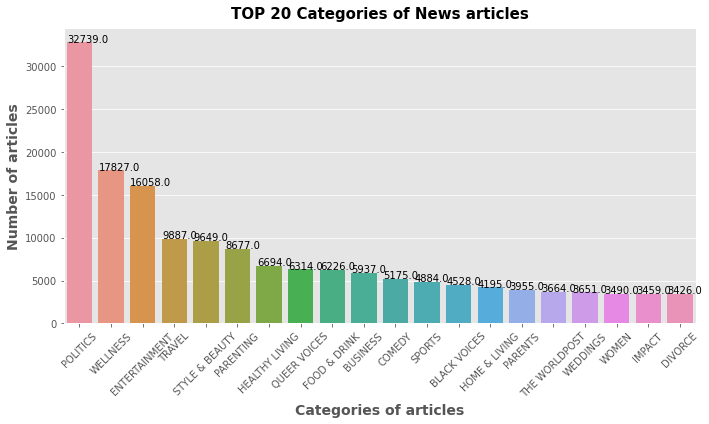

In [ ]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_data['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

# Visualize top 20 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(np.array(cat_df.news_classes)[:20], np.array(cat_df.numcat)[:20])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("TOP 20 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

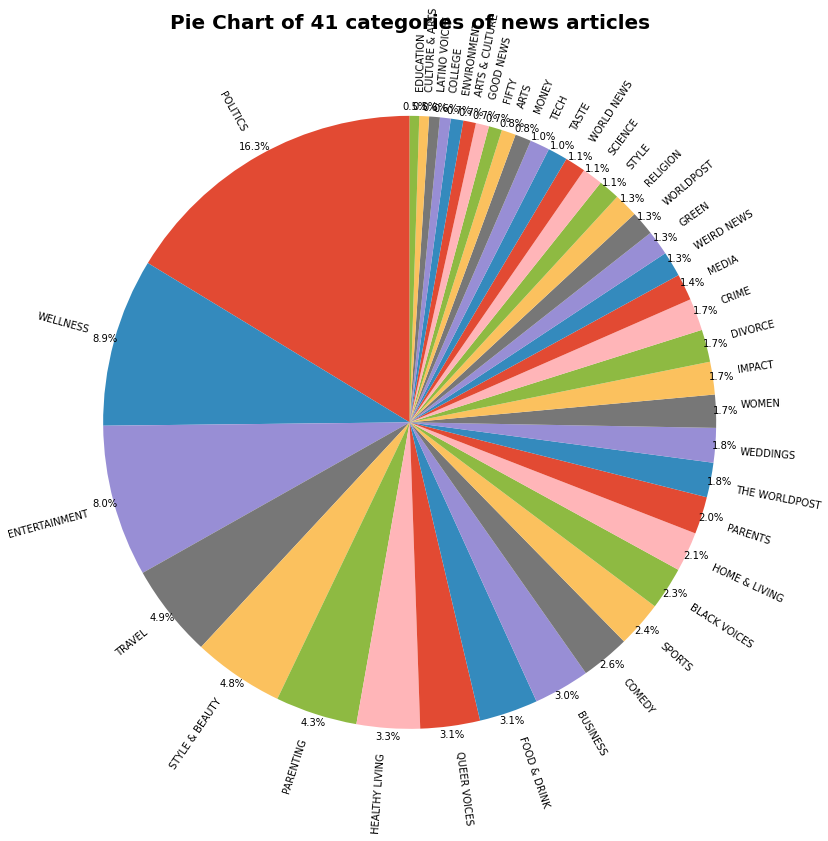

In [ ]:
# plot the pie chart of 41 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:41],
            labels=cat_df['news_classes'][:41],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of 41 categories of news articles", size=20, weight='bold')
plt.show()

In [ ]:
new_data=new_data[new_data.category.isin(['BUSINESS', 'ENTERTAINMENT','POLITICS','SPORTS','TECH'])]

We will only use 5 categories news among 41 unique categories:
1. business: 5937 (3.0%)
2. entertainment: 16058 (8.0%)
3. politics: 32739 (16.3%)
4. sports: 4884 (2.4%)
5. tech: 2082 (1.0%)

In [ ]:
# create final dataframe of combined headline and short_description
final_data = new_data.copy()
final_data['length_of_news'] = final_data['headline'] + final_data['short_description']
final_data.drop(['headline','short_description'], inplace=True, axis=1)
final_data['len_news'] = final_data['length_of_news'].map(lambda x: len(x))
final_data.head()

,category,length_of_news,len_news
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,99
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,134
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,155
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,158
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,205


In [ ]:
# maximum length of news in each category
lenmax_df = final_data.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
2,POLITICS,1486
0,BUSINESS,950
1,ENTERTAINMENT,541
4,TECH,483
3,SPORTS,462


In [ ]:
# minimum lenght of news in each category
lenmin_df = final_data.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
4,TECH,17
1,ENTERTAINMENT,6
3,SPORTS,3
0,BUSINESS,0
2,POLITICS,0


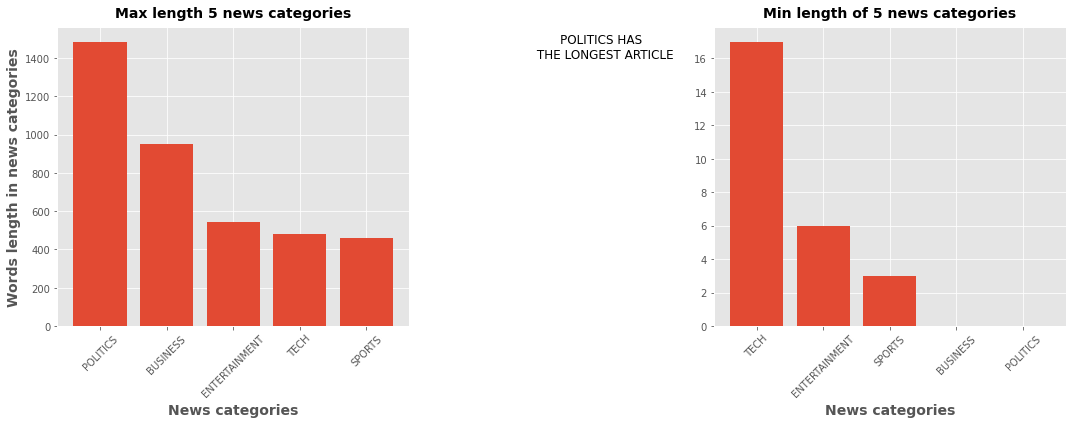

In [ ]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:5],lenmax_df['len_news'][:5])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length 5 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:5], lenmin_df['len_news'][:5])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of 5 news categories", size=14)

plt.show()

1. POLITICS has the most number of articles as well as length of characters in the article.
2. After 'POLITICS' category, 'BUSINESS' and 'ENTERTAINMENT' are in top 3 most length of articles.
3. 'POLITICS', 'BUSINESS' and 'ENTERTAINMENT' are top 3 categories having most number of articles in the dataset.

(-0.5, 1599.5, 599.5, -0.5)

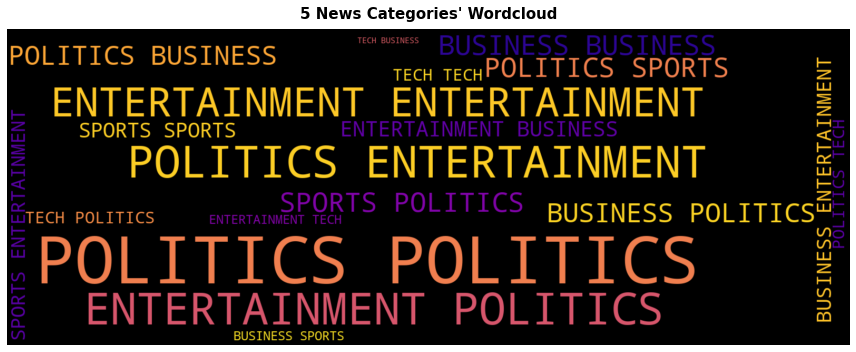

In [ ]:
# wordcloud of categories of news articles in the dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_data.category))

plt.title("5 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

In [ ]:
ndf = final_data.copy()
ndf.drop('len_news', inplace=True, axis=1)
print(ndf)

             category                                     length_of_news
1       ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...
2       ENTERTAINMENT  Hugh Grant Marries For The First Time At Age 5...
3       ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4       ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...
5       ENTERTAINMENT  Morgan Freeman 'Devastated' That Sexual Harass...
...               ...                                                ...
200848           TECH  RIM CEO Thorsten Heins' 'Significant' Plans Fo...
200849         SPORTS  Maria Sharapova Stunned By Victoria Azarenka I...
200850         SPORTS  Giants Over Patriots, Jets Over Colts Among  M...
200851         SPORTS  Aldon Smith Arrested: 49ers Linebacker Busted ...
200852         SPORTS  Dwight Howard Rips Teammates After Magic Loss ...

[61700 rows x 2 columns]


In [ ]:
#Text data preprocessing
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence) 

In [ ]:
# Example of pre-processing using above function
import nltk
nltk.download('wordnet')
print("Text sentence before pre-processing:\n",ndf['length_of_news'][1])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(ndf['length_of_news'][1]))

[nltk_data] Downloading package wordnet to /root/nltk_data...


Text sentence before pre-processing:
 Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official SongOf course it has a song.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 will smith join diplo nicky jam world cup official songof course song


In [ ]:
# apply datacleaning function to column 'length_of_news'
ndf['length_of_news'] = ndf['length_of_news'].apply(datacleaning)

In [ ]:
# length of total characters
original_length = ndf['length_of_news'].apply(len).sum()
print(f"chracters length of text data: {original_length}")

chracters length of text data: 6806869


In [ ]:
# length of total words
original_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"word length of text data: {original_text}")

word length of text data: 961788


In [ ]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(ndf['length_of_news'][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words
            
max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1)) 

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 76)
Token index of unique words: 
 {'will': 1, 'smith': 2, 'join': 3, 'diplo': 4, 'nicky': 5, 'jam': 6, 'world': 7, 'cup': 8, 'official': 9, 'songof': 10, 'course': 11, 'song': 12, 'hugh': 13, 'grant': 14, 'marry': 15, 'first': 16, 'time': 17, 'age': 18, 'actor': 19, 'longtime': 20, 'girlfriend': 21, 'anna': 22, 'eberstein': 23, 'tie': 24, 'knot': 25, 'civil': 26, 'ceremony': 27, 'jim': 28, 'carrey': 29, 'blast': 30, 'castrato': 31, 'adam': 32, 'schiff': 33, 'democrats': 34, 'new': 35, 'artworkthe': 36, 'give': 37, 'dems': 38, 'asskicking': 39, 'fight': 40, 'hard': 41, 'enough': 42, 'donald': 43, 'trump': 44, 'julianna': 45, 'margulies': 46, 'use': 47, 'poop': 48, 'bag': 49, 'pick': 50, 'dogthe': 51, 'dietland': 52, 'actress': 53, 'say': 54, 'really': 55, 'cathartic': 56, 'therapeutic': 57, 'moment': 58, 'morgan': 59, 'freeman': 60, 'devastate': 61, 'sexual': 62, 'harassment': 63, 'claim': 64, 'undermine': 65, 'legacyit': 66, 'right': 67, 'equate'

In [ ]:
# one hot encoding using keras tokenizer and pad sequencing
X = ndf['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=100) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=100)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 100 # max length of sequence 
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)
print("Length of word index:", total_words)

shape of input data:  (61700,)
shape of target variable:  (61700,)
Length of word index: 72074


In [ ]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words+1, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 70)           5045250   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 128)         17280     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 128)         24704     
 nal)                                                            
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 5)                 1

In [ ]:
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, 
                   batch_size=128, 
                    epochs=15, 
                    validation_split=0.2
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
309/309 [==============================] - 159s 450ms/step - loss: 1.1813 - accuracy: 0.5636 - val_loss: 0.8536 - val_accuracy: 0.7083
Epoch 2/15
309/309 [==============================] - 132s 429ms/step - loss: 0.7044 - accuracy: 0.7629 - val_loss: 0.5399 - val_accuracy: 0.8295
Epoch 3/15
309/309 [==============================] - 133s 430ms/step - loss: 0.5106 - accuracy: 0.8314 - val_loss: 0.5151 - val_accuracy: 0.8453
Epoch 4/15
309/309 [==============================] - 133s 429ms/step - loss: 0.4118 - accuracy: 0.8676 - val_loss: 0.5374 - val_accuracy: 0.8407
Epoch 5/15
309/309 [==============================] - 132s 427ms/step - loss: 0.3486 - accuracy: 0.8907 - val_loss: 0.5185 - val_accuracy: 0.8500
Epoch 6/15
309/309 [==============================] - 133s 431ms/step - loss: 0.2980 - accuracy: 0.9104 - val_loss: 0.5911 - val_accuracy: 0.8315
Epoch 7/15
309/309 [==============================] - 134s 433ms/step - loss: 0.2655 - accuracy: 0.9227 - val_loss: 0.5635 -

In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words+1, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(76, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          7207500   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 128)         24704     
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 98, 76)            29260     
                                                      

In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, y_train, 
                     batch_size=128, 
                     epochs=15, 
                     validation_split=0.2,
                     shuffle=True
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/15
309/309 [==============================] - 571s 2s/step - loss: 1.7712 - accuracy: 0.7328 - val_loss: 0.5802 - val_accuracy: 0.8260
Epoch 2/15
309/309 [==============================] - 550s 2s/step - loss: 0.4788 - accuracy: 0.8646 - val_loss: 0.5339 - val_accuracy: 0.8451
Epoch 3/15
309/309 [==============================] - 550s 2s/step - loss: 0.3760 - accuracy: 0.9008 - val_loss: 0.5524 - val_accuracy: 0.8433
Epoch 4/15
309/309 [==============================] - 549s 2s/step - loss: 0.3067 - accuracy: 0.9256 - val_loss: 0.5160 - val_accuracy: 0.8605
Epoch 5/15
309/309 [==============================] - 548s 2s/step - loss: 0.2527 - accuracy: 0.9428 - val_loss: 0.5452 - val_accuracy: 0.8566
Epoch 6/15
309/309 [==============================] - 548s 2s/step - loss: 0.2092 - accuracy: 0.9568 - val_loss: 0.5907 - val_accuracy: 0.8641
Epoch 7/15
309/309 [==============================] - 549s 2s/step - loss: 0.1770 - accuracy: 0.9667 - val_loss: 0.6020 - val_accuracy: 0.8584

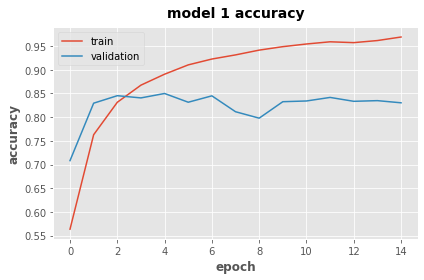

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

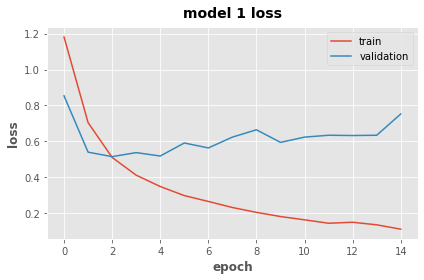

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[ 619  115  355   72   36]
 [  27 2897  234   54    7]
 [ 202  361 5884   47   21]
 [  26  283   45  628   10]
 [  77   70  119   14  137]]


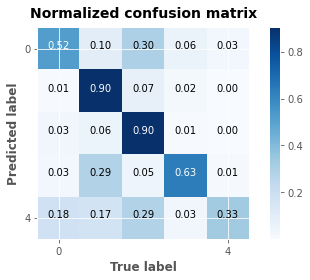

In [ ]:
#Evaluate model 1
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_padseq))
cm1 = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm1)

cm1 = cm1.astype('float') / cm1.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm1, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 4]); plt.yticks([0, 4])
plt.grid('off')
for i, j in itertools.product(range(cm1.shape[0]), range(cm1.shape[1])):
    plt.text(j, i, format(cm1[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm1[i, j] > 0.5 else 'black')

In [ ]:
total=sum(sum(cm1))
accuracy=(cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3]+cm1[4,4])/total
print ('Accuracy : ', accuracy)

sensitivity_business = cm1[0,0]/(cm1[0,0]+cm1[1,0]+cm1[2,0]+cm1[3,0]+cm1[4,0])
print('Sensitivity for business : ', sensitivity_business )

sensitivity_entertainment = cm1[1,1]/(cm1[1,1]+cm1[0,1]+cm1[2,1]+cm1[3,1]+cm1[4,1])
print('Sensitivity for entertainment : ', sensitivity_entertainment )

sensitivity_politics = cm1[2,2]/(cm1[2,2]+cm1[0,2]+cm1[1,2]+cm1[3,2]+cm1[4,2])
print('Sensitivity for politics : ', sensitivity_politics )

sensitivity_sports = cm1[3,3]/(cm1[3,3]+cm1[0,3]+cm1[1,3]+cm1[2,3]+cm1[4,3])
print('Sensitivity for sports : ', sensitivity_sports )

sensitivity_tech = cm1[4,4]/(cm1[4,4]+cm1[0,4]+cm1[1,4]+cm1[2,4]+cm1[3,4])
print('Sensitivity for tech : ', sensitivity_tech )

Accuracy :  0.6563686708707818
Sensitivity for business :  0.673884330039449
Sensitivity for entertainment :  0.5981445776350955
Sensitivity for politics :  0.5633577359489665
Sensitivity for sports :  0.8432118346773754
Sensitivity for tech :  0.8782281270630188


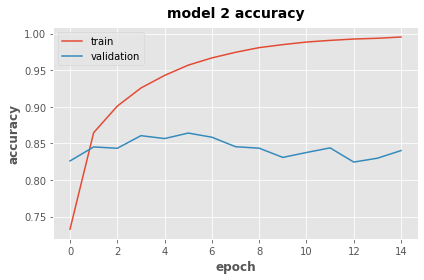

In [ ]:
plt.figure()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

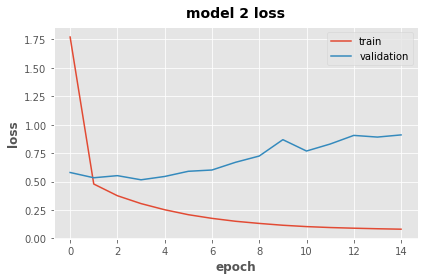

In [ ]:
plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[ 691   52  371   14   69]
 [  74 2695  323  107   20]
 [ 224  126 6050   67   48]
 [  34   80   86  770   22]
 [  94   27   63   10  223]]


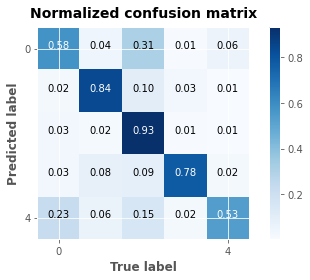

In [ ]:
#Evaluate model 2
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model2.predict(np.stack(test_padseq))
cm2 = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm2)

cm2 = cm2.astype('float') / cm2.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm2, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 4]); plt.yticks([0, 4])
plt.grid('off')
for i, j in itertools.product(range(cm2.shape[0]), range(cm2.shape[1])):
    plt.text(j, i, format(cm2[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm2[i, j] > 0.5 else 'black')

In [ ]:
total=sum(sum(cm2))
accuracy=(cm2[0,0]+cm2[1,1]+cm2[2,2]+cm2[3,3]+cm2[4,4])/total
print ('Accuracy : ', accuracy)

sensitivity_business = cm2[0,0]/(cm2[0,0]+cm2[1,0]+cm2[2,0]+cm2[3,0]+cm2[4,0])
print('Sensitivity for business : ', sensitivity_business )

sensitivity_entertainment = cm2[1,1]/(cm2[1,1]+cm2[0,1]+cm2[2,1]+cm2[3,1]+cm2[4,1])
print('Sensitivity for entertainment : ', sensitivity_entertainment )

sensitivity_politics = cm2[2,2]/(cm2[2,2]+cm2[0,2]+cm2[1,2]+cm2[3,2]+cm2[4,2])
print('Sensitivity for politics : ', sensitivity_politics )

sensitivity_sports = cm2[3,3]/(cm2[3,3]+cm2[0,3]+cm2[1,3]+cm2[2,3]+cm2[4,3])
print('Sensitivity for sports : ', sensitivity_sports )

sensitivity_tech = cm2[4,4]/(cm2[4,4]+cm2[0,4]+cm2[1,4]+cm2[2,4]+cm2[3,4])
print('Sensitivity for tech : ', sensitivity_tech )

Accuracy :  0.7308202316624444
Sensitivity for business :  0.6454769164977737
Sensitivity for entertainment :  0.8008638645497271
Sensitivity for politics :  0.5889749136589895
Sensitivity for sports :  0.9074119163452502
Sensitivity for tech :  0.851311598616831
